In [1]:
import os
from PIL import Image
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from resnet import resnet18
from tensorboardX import SummaryWriter

from radam import RAdam

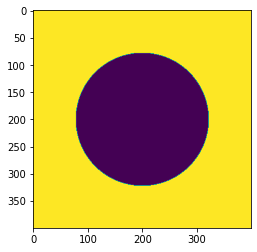

In [2]:
#create mask
mask2 = np.ones((400, 400), dtype=np.uint8)
for i in range(400):
    for j in range(400):
        if ((i - 200)**2 + (j - 200)**2) < 122**2:
            mask2[i, j] = 0
plt.imshow(mask2)

In [3]:
class Planck(Dataset):
    def __init__(self, root='./data/train', split='None'):
        self.frequencies = ['100', '143', '217', '353', '545']
        
        # 70/15/15
        train_indices, test_indices = train_test_split(range(1000), test_size=0.3, random_state=9)
        val_indices, test_indices = train_test_split(test_indices, test_size=0.5, random_state=9)
        
        if split == 'train':
            indices = train_indices
        elif split == 'val':
            indices = val_indices
        elif split == 'test':
            indices = test_indices
        else:
            raise Exception()
        self.is_train = split == 'train'
        
        names_effect = list([x.split('_')[0] for x in os.listdir(f'{root}/effect/pl100/')])
        names_no_effect = list([x.split('_')[0] for x in os.listdir(f'{root}/no_effect/s100_rand/')])
        
        self.images = []
        for idx in indices:
            name_effect = names_effect[idx]
            imgs_effect = [self.open_image(f'{root}/effect/pl{f}/{name_effect}_{f}_gr.gif')
                           for f in self.frequencies]
            self.images.append((imgs_effect, 1))
            
            name_no_effect = names_no_effect[idx]
            imgs_no_effects = [self.open_image(f'{root}/no_effect/s{f}_rand/{name_no_effect}_{f}_gr.gif')
                               for f in self.frequencies]
            self.images.append((imgs_no_effects, 0))

    def __len__(self):
        return len(self.images)
    
    def open_image(self, path):
        img = Image.open(path)
        img = np.asarray(img, dtype=np.uint8).copy()
        img[mask2 == 1] = 255
        img = Image.fromarray(img)
        return img
        
    def prepare(self, imgs, angle, x_shift, y_shift):
        features = []
        for img in imgs:
            img = img.resize((96, 96), Image.NEAREST)
            if self.is_train:
                img = img.rotate(angle)
            img = (np.asarray(img, dtype=np.float32) / 255)
            if self.is_train:
                img = np.roll(img, x_shift, axis=0)
                img = np.roll(img, y_shift, axis=1)
            img = img[16:-16, 16:-16]
            mask_img = img == 1
            img[mask_img] = -1
            features.append(img)
        return np.stack(features, axis=0)
    
    def __getitem__(self, idx):
        imgs, answer = self.images[idx]
        angle = np.random.randint(0, 360)
        x_shift, y_shift = np.random.randint(-5, 6), np.random.randint(-5, 5)
        X = self.prepare(imgs, angle, x_shift, y_shift)
        return X, answer

In [4]:
def accuracy(y_pred, y_true, threshold=0.5):
    return (torch.abs(y_true - (F.sigmoid(y_pred) > threshold).float()) < 0.5).float().mean().item()

# Train

In [5]:
device = 'cpu'
name = 'try_bce6'
batch_size = 50
n_epochs = 150

try:
    os.mkdir(f'./checkpoints/{name}')
except Exception as e:
    print(e)

[Errno 17] File exists: './checkpoints/try_bce6'


In [6]:
train_dataset, val_dataset = Planck(split='train'), Planck(split='val')
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

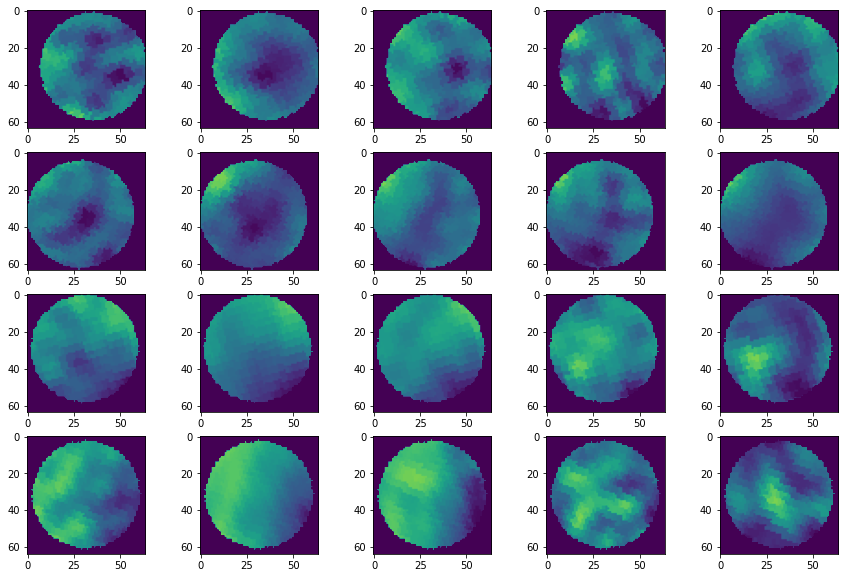

In [7]:
img_effect_1, _ = train_dataset.__getitem__(0)
img_effect_2, _ = train_dataset.__getitem__(4)
img_no_effect_1, _ = train_dataset.__getitem__(300)
img_no_effect_2, _ = train_dataset.__getitem__(304)

fig, ax = plt.subplots(4, 5, figsize=(15, 10))
for i in range(5):
    ax[0][i].imshow(img_effect_1[i], vmin=0, vmax=0.5)
    ax[1][i].imshow(img_effect_2[i], vmin=0, vmax=0.5)
    ax[2][i].imshow(img_no_effect_1[i], vmin=0, vmax=0.5)
    ax[3][i].imshow(img_no_effect_2[i], vmin=0, vmax=0.5)

In [8]:
model = resnet18(num_classes=1).to(device)
optimizer = RAdam(model.parameters(), lr=0.0002)
scheduler = StepLR(optimizer, step_size=100, gamma=0.2)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
writer = SummaryWriter(log_dir=f'./logs/{name}')

best_val_loss = np.inf
for epoch in tqdm(range(n_epochs)):
    scheduler.step()
    writer.add_scalar('train/lr', scheduler.get_lr(), epoch)
    
    model.train()
    for idx, batch in enumerate(train_dataloader):
        X, y_true = batch
        X, y_true = X.to(device), y_true.unsqueeze(1).float().to(device)

        optimizer.zero_grad()

        y_pred = model(X)

        loss = criterion(y_pred, y_true)
        loss.backward()

        optimizer.step()
        
        loss = loss.detach()
        acc = accuracy(y_pred.detach(), y_true)
        
        writer.add_scalar('train/loss', loss, epoch * len(train_dataloader) + idx)
        writer.add_scalar('train/acc', acc, epoch * len(train_dataloader) + idx)
        writer.file_writer.flush()
    
    with torch.no_grad():
        model.eval()
        val_loss, val_acc, steps = 0, 0, 0
        for idx, batch in enumerate(val_dataloader):
            X, y_true = batch
            X, y_true = X.to(device), y_true.unsqueeze(1).float().to(device)

            y_pred = model(X)

            loss = criterion(y_pred, y_true)

            val_loss += loss.detach()
            val_acc += accuracy(y_pred.detach(), y_true)
            steps += 1
            
        val_loss /= steps
        val_acc /= steps
        
        writer.add_scalar('val/loss', val_loss, epoch)
        writer.add_scalar('val/acc', val_acc, epoch)
        writer.file_writer.flush()
        
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'./checkpoints/{name}/net_{epoch}.pt')
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), f'./checkpoints/{name}/net_best.pt')
        best_val_loss = val_loss
    torch.save(model.state_dict(), f'./checkpoints/{name}/net_last.pt')

# Find threshold of best model

In [ ]:
best_checkpoint_name = f'./checkpoints/{name}/net_best.pt'
model.load_state_dict(torch.load(best_checkpoint_name))
model.eval();

In [30]:
best_t, best_acc = 0, 0
for t in np.linspace(0, 1, 51):
    steps, test_acc = 0, 0.
    for idx, batch in enumerate(val_dataloader):
        X, y_true = batch
        X, y_true = X.to(device), y_true.unsqueeze(1).float().to(device)
        y_pred = torch.sigmoid(model(X))

        steps += 1
        test_acc += accuracy(y_pred.detach(), y_true, threshold=t)
    test_acc /= steps
    print(f'{t:.2f}, {test_acc:.3f}')
    if test_acc > best_acc:
        best_t, best_acc = t, test_acc
print(f'best {best_t:.2f}, acc: {best_acc:.3f}')

0.00, 0.500
0.02, 0.500
0.04, 0.500
0.06, 0.500
0.08, 0.500
0.10, 0.500
0.12, 0.500
0.14, 0.500
0.16, 0.500
0.18, 0.500
0.20, 0.500
0.22, 0.500
0.24, 0.500
0.26, 0.500
0.28, 0.500
0.30, 0.500
0.32, 0.500
0.34, 0.500
0.36, 0.500
0.38, 0.500
0.40, 0.500
0.42, 0.500
0.44, 0.500
0.46, 0.500
0.48, 0.500
0.50, 0.500
0.52, 0.833
0.54, 0.883
0.56, 0.887
0.58, 0.900
0.60, 0.900
0.62, 0.893
0.64, 0.893
0.66, 0.883
0.68, 0.870
0.70, 0.853
0.72, 0.817
0.74, 0.500
0.76, 0.500
0.78, 0.500
0.80, 0.500
0.82, 0.500
0.84, 0.500
0.86, 0.500
0.88, 0.500
0.90, 0.500
0.92, 0.500
0.94, 0.500
0.96, 0.500
0.98, 0.500
1.00, 0.500
best 0.58, acc: 0.900


# Apply on test with best theshold

In [19]:
test_dataset = Planck(split='test')
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [15]:
for t in [0.5, best_t]:
    steps, test_acc = 0, 0
    for idx, batch in enumerate(test_dataloader):
        X, y_true = batch
        X, y_true = X.to(device), y_true.unsqueeze(1).float().to(device)
        y_pred = model(X)

        steps += 1
        test_acc += accuracy(y_pred.detach(), y_true, threshold=best_t)
    test_acc /= steps

    print(f'{t:.2f}, acc: {test_acc:.3f}')

NameError: name 'best_t' is not defined

# Apply (with load chckpoint)

In [31]:
checkpoint_name = './checkpoints/try_bce6/net_best.pt'
threshold = 0.58
model.load_state_dict(torch.load(checkpoint_name, map_location=torch.device('cpu')))
model.eval();

In [43]:
steps, test_acc = 0, 0
recall_steps, test_recall = 0, 0
for idx, batch in enumerate(test_dataloader):
    X, y_true = batch
    X, y_true = X.to(device), y_true.unsqueeze(1).float().to(device)
    y_pred = torch.sigmoid(model(X))

    steps += 1
    test_acc += (y_pred.item() > threshold) == y_true.item()
    if y_true.item() == 1:
        recall_steps += 1
        test_recall += (y_pred.item() > threshold) == y_true.item()
test_acc /= steps
test_recall /= recall_steps

print(f'acc: {test_acc:.3f}')
print(f'recall: {test_recall:.3f}')

acc: 0.890
recall: 0.867


In [44]:
test_recall

0.8666666666666667

In [27]:
torch.sigmoid(y_pred.detach()).item()

0.019945038482546806

In [35]:
y_pred.item()

0.019945038482546806